## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'


!wget -nc $data

File 'AB_NYC_2019.csv' already there; not retrieving.



In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [4]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


<AxesSubplot:xlabel='price', ylabel='Count'>

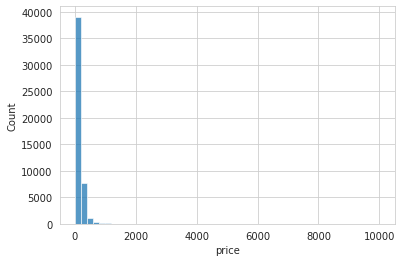

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("whitegrid")



sns.histplot(df.price,bins=50) #bins , how many bars?


Applying the logarithmic transformation to the price is necessary .

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
df.price = np.log1p(df.price.values)

<AxesSubplot:xlabel='price', ylabel='Count'>

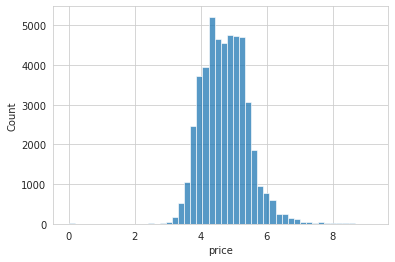

In [7]:

sns.histplot(df.price,bins=50) 


In [8]:
# Spliting the data with train test split (Cross validation)


from sklearn.model_selection import train_test_split

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)

df_train , df_val = train_test_split(df_full_train,test_size=0.25,random_state=1) # From full train split


In [9]:
len(df),len(df_full_train),len(df_test),len(df_train),len(df_val) # lenghts of the data sets

(48895, 39116, 9779, 29337, 9779)

In [10]:
# Resseting indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [11]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [12]:

del df_train['price']
del df_val['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [13]:
from sklearn.feature_extraction import DictVectorizer

# train data set:

# checking missing values
df.isnull().sum()
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')

In [14]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn import tree
import sklearn

import graphviz


Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [21]:
# training a decision tree Regressor

dr = DecisionTreeRegressor(max_depth=1)
dr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

/home/elegant00/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


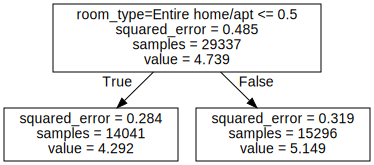

In [22]:
from sklearn import tree

from IPython.display import display
display(graphviz.Source(tree.export_graphviz(dr,feature_names=dv.get_feature_names())))

Answer: room_type


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [30]:
# training a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



In [37]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

rms = mean_squared_error(y_val, y_pred, squared=False)
round(rms,3)


0.46

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

Answer: 0.45

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [42]:
rmse_score = []

for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i,random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    rms = mean_squared_error(y_val, y_pred, squared=False)
    rmse_score.append(rms)
    print('%s -> %.3f' % (i, round(rms,3)))




10 -> 0.460
20 -> 0.448
30 -> 0.445
40 -> 0.443
50 -> 0.442
60 -> 0.442
70 -> 0.441
80 -> 0.441
90 -> 0.440
100 -> 0.440
110 -> 0.439
120 -> 0.439
130 -> 0.439
140 -> 0.439
150 -> 0.439
160 -> 0.439
170 -> 0.439
180 -> 0.439
190 -> 0.439
200 -> 0.439


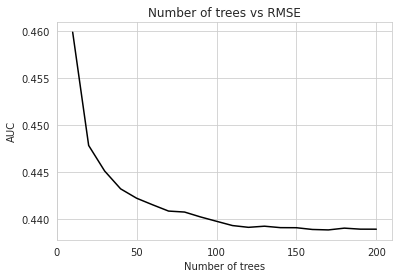

In [44]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), rmse_score, color='black')
plt.xticks(range(0, 201, 50))

plt.title('Number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

Answer: 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [45]:
#Tunning the max_depth parameter:


all_rmse = {} # DICT OF VALUES


for depth in [10, 15, 20, 25]:
    print('depth: %s' % depth)
    rmse = []
    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i,max_depth=depth,random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        rms = mean_squared_error(y_val, y_pred, squared=False)
        rmse.append(rms)
        print('%s -> %.3f' % (i, round(rms,3)))

    
    all_rmse[depth] = rmse
    print()

depth: 10
10 -> 0.446
20 -> 0.442
30 -> 0.441
40 -> 0.442
50 -> 0.441
60 -> 0.441
70 -> 0.441
80 -> 0.441
90 -> 0.440
100 -> 0.440
110 -> 0.440
120 -> 0.440
130 -> 0.440
140 -> 0.440
150 -> 0.440
160 -> 0.440
170 -> 0.440
180 -> 0.440
190 -> 0.440
200 -> 0.440

depth: 15
10 -> 0.450
20 -> 0.441
30 -> 0.439
40 -> 0.439
50 -> 0.438
60 -> 0.438
70 -> 0.437
80 -> 0.437
90 -> 0.437
100 -> 0.437
110 -> 0.436
120 -> 0.436
130 -> 0.436
140 -> 0.436
150 -> 0.436
160 -> 0.436
170 -> 0.436
180 -> 0.436
190 -> 0.436
200 -> 0.436

depth: 20
10 -> 0.460
20 -> 0.447
30 -> 0.444
40 -> 0.442
50 -> 0.441
60 -> 0.441
70 -> 0.440
80 -> 0.440
90 -> 0.439
100 -> 0.439
110 -> 0.438
120 -> 0.438
130 -> 0.438
140 -> 0.438
150 -> 0.438
160 -> 0.438
170 -> 0.438
180 -> 0.438
190 -> 0.438
200 -> 0.438

depth: 25
10 -> 0.461
20 -> 0.448
30 -> 0.445
40 -> 0.443
50 -> 0.442
60 -> 0.442
70 -> 0.441
80 -> 0.441
90 -> 0.441
100 -> 0.440
110 -> 0.440
120 -> 0.439
130 -> 0.440
140 -> 0.439
150 -> 0.439
160 -> 0.439
170 -

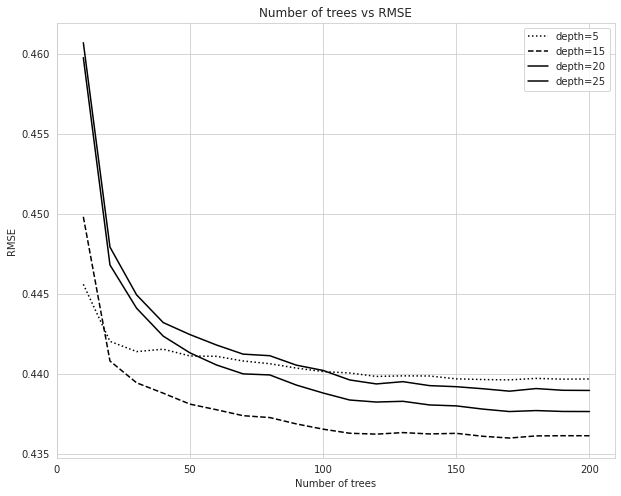

In [53]:
# Number of trees VS ROC AND MAX DEPTH

plt.figure(figsize=((10,8)))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_rmse[10], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_rmse[15], label='depth=15', color='black', linestyle='dashed')
plt.plot(num_trees, all_rmse[20], label='depth=20', color='black', linestyle='solid')
plt.plot(num_trees, all_rmse[25], label='depth=25', color='black', linestyle='solid')


plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [54]:
rf = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

/home/elegant00/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<BarContainer object of 15 artists>

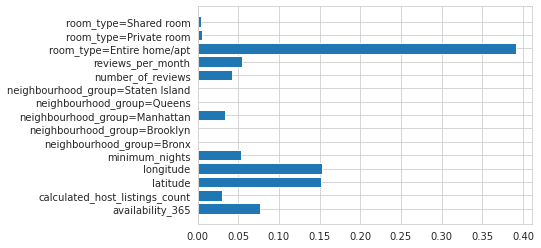

In [56]:
rf.feature_importances_
plt.barh(dv.get_feature_names(), rf.feature_importances_)


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

Answer: Room_type = Entire home/apt

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [58]:
import xgboost as xgb


## Creating the DMatrix 



In [86]:
dv.feature_names_

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [80]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)


In [81]:
watchlist = [(dtrain, 'train'), (dval, 'val')]


Now change `eta` first to `0.1` and then to `0.01`

In [87]:
def parse_xgb_output(output):
    tree = []
    rmse_train = []
    rmse_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        rmse_train.append(train)
        rmse_val.append(val)

    return tree, rmse_train, rmse_val

In [88]:

%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100, verbose_eval=10,
                  evals=watchlist)

In [89]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))


3.02415
(3.02415, 0)


#for 0.1

In [90]:

%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100, verbose_eval=10,
                  evals=watchlist)

In [71]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))


3.86889
(3.86889, 0)


In [91]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100, verbose_eval=10,
                  evals=watchlist)

In [92]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))


4.2501
(4.2501, 0)


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

